In [1]:
from gensim.models import Word2Vec
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
np.random.seed(0)

CONTEXT_SIZE = 2

text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nunc eu sem 
scelerisque, dictum eros aliquam, accumsan quam. Pellentesque tempus, lorem ut 
semper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis 
nulla. Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor 
scelerisque. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices 
posuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan. Duis 
vulputate massa sit amet viverra hendrerit. Integer maximus quis sapien id 
convallis. Donec elementum placerat ex laoreet gravida. Praesent quis enim 
facilisis, bibendum est nec, pharetra ex. Etiam pharetra congue justo, eget 
imperdiet diam varius non. Mauris dolor lectus, interdum in laoreet quis, 
faucibus vitae velit. Donec lacinia dui eget maximus cursus. Class aptent taciti
sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vivamus
tincidunt velit eget nisi ornare convallis. Pellentesque habitant morbi 
tristique senectus et netus et malesuada fames ac turpis egestas. Donec 
tristique ultrices tortor at accumsan.
""".split()

skipgrams = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    array = [text[j] for j in np.arange(i - CONTEXT_SIZE, i + CONTEXT_SIZE + 1) if j != i]
    skipgrams.append((text[i], array))

print(skipgrams[0:2])

[('dolor', ['Lorem', 'ipsum', 'sit', 'amet,']), ('sit', ['ipsum', 'dolor', 'amet,', 'consectetur'])]


In [3]:
vocab = set(text)
VOCAB_SIZE = len(vocab)
print(f"Length of vocabulary = {VOCAB_SIZE}")

Length of vocabulary = 121


In [4]:
model = Word2Vec(
    sentences=[text],
    sg=1,               # Skip-gram model
    vector_size=15,     # Increase dimensionality to 15
    min_count=1,        # Ignore words with frequency less than 1
    window=5,           # Increase the context window size to 5
    workers=2,          # Use 2 CPU cores for training
    seed=42             # Change the random seed to 42
)

print(f'Shape of W_embed: {model.wv.vectors.shape}')

# Training the model .
model.train(text, total_examples=model.corpus_count, epochs=10)
# Printing the Word embedding .
print('\nWord embedding =')
print(model.wv[0])

Shape of W_embed: (121, 15)

Word embedding =
[-0.05472368  0.03819067  0.02033633 -0.00692234 -0.00842776  0.04770215
 -0.05632092  0.02441295 -0.03908686 -0.05261745  0.00332267  0.06408791
  0.03144152  0.03352187  0.02830095]


/opt/conda/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


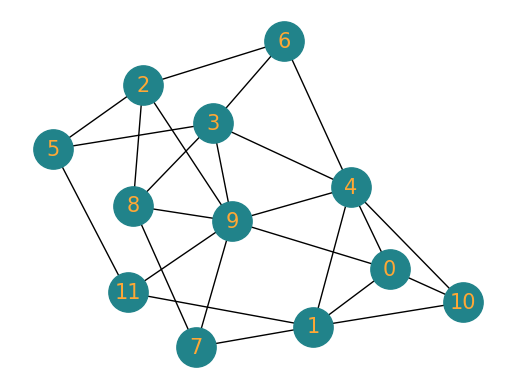

In [5]:
G = nx.erdos_renyi_graph(12, 0.4, seed=1, directed=False)

# Plot graph
plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=800,
                 node_color='#21838A',
                 cmap='#135353',
                 font_size=15,
                 font_color='#FFA835'
                 )
# node_color = #21838A ---> Cyan 
# cmap = #135353 ---> Charcoal_Gray 
# font_color = #FFA835 ---> saffron 

In [6]:
random.seed(0)

def random_walk(start, length):
    walk = [str(start)]  
    
    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node
    
    return walk


print(random_walk(0, 12))

['0', '1', '0', '10', '1', '10', '1', '7', '1', '0', '1', '11', '9']


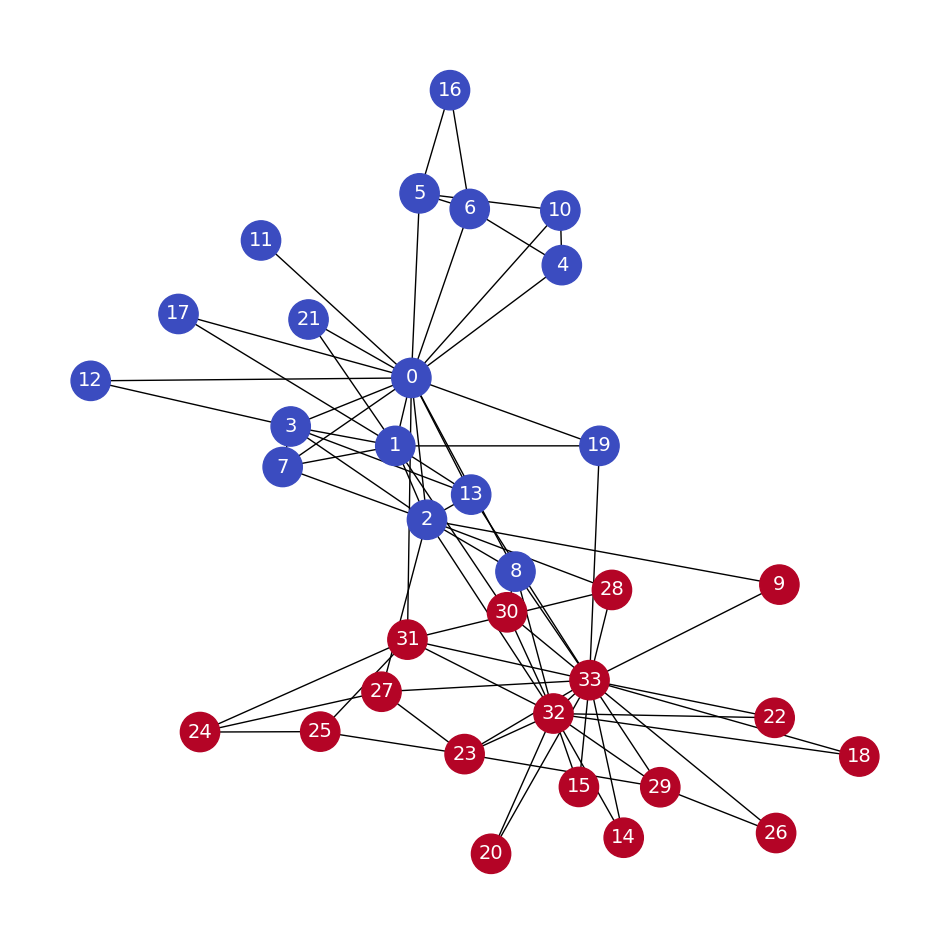

In [7]:
G = nx.karate_club_graph()
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Plot graph
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size=800,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [8]:
# Create a list of random walks
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10))

# Print the first random walk
print(walks[0])

['0', '2', '13', '0', '2', '9', '33', '30', '1', '13', '3']


In [9]:
# Create Word2Vec
model = Word2Vec(walks,
                 hs=1,   # Hierarchical softmax
                 sg=1,   # Skip-gram
                 vector_size=100,
                 window=10,
                 workers=1,
                 seed=1)

print(f'Shape of embedding matrix: {model.wv.vectors.shape}')

# Build vocabulary
model.build_vocab(walks)

# Train model
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

Shape of embedding matrix: (34, 100)


(187290, 897600)

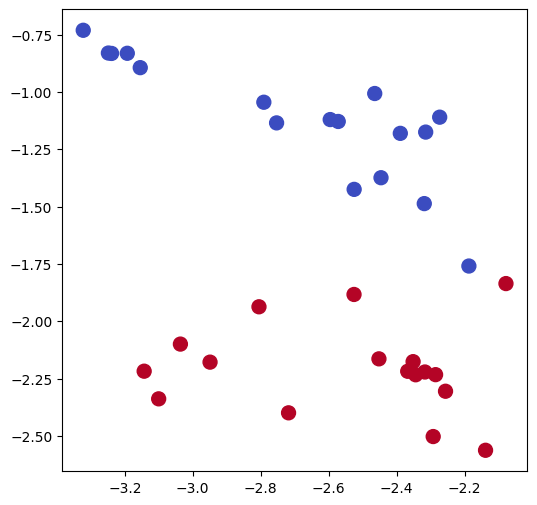

In [10]:
# Preprocess word vectors and label
nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
labels = np.array(labels)

# Train TSNE
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(nodes_wv)

# Plot TSNE
plt.figure(figsize=(6, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
plt.show()

In [11]:
# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]

# Train classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(nodes_wv[train_mask], labels[train_mask])

# Evaluate accuracy
y_pred = clf.predict(nodes_wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Accuracy = {acc*100:.2f}%')

Accuracy = 95.45%
